## Implementation of Isolation Forest to Detect Outliers

### 1. Setup
#### 1.1. Input data

The data "sample_detect_outliers.csv" contains US public firms' characteristics that are related to leases. This data is used in my UC Berkeley Haas PhD dissertation.

#### 1.2. Output data
The following lines of code will output an indicator variable that equals 1 if the instance (e.g., observation) is an outlier and 0 otherwise. For more details on the steps after I identify outliers, please see my dissertation, <a href="https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3689446">Yoon (2022)</a>.

#### 1.3. Feature (i.e., variable) definition
lag_lease: prior year's lease activity
lag_market_value: prior year's market capitalization of the stock
lag_dividend: an indicator value that equals 1 if the company paid any dividends in the prior, and 0 otherwise
lag_loss: an indicator value that equals 1 if the company reported negative profits in the prior year
lag_cash: prior year's cash balance
lag_tax_rate: effective tax rate in the prior year
lag_big4_auditor: an indicator value that equals 1 if the company hired a Big 4 auditor in the prior year

#### 1.4. Import libraries and the data set

In [343]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [344]:
# Import the data set
sample_with_outliers = pd.read_csv('sample_detect_outliers.csv')

### 2. Conduct an Exploratory Data Analysis (EDA)
#### 2.1. Show the first 5 entries in the data

In [345]:
# First 5 entries
sample_with_outliers.head()

,identifier,lease,lag_lease,lag_market_value,lag_dividend,lag_loss,lag_cash,lag_tax_rate,lag_big4_auditor
0,1004,1.716172,1.300330,6.953107,0.007855,0,0.036106,0.362751,1
1,1004,1.664240,1.802926,6.736387,0.007212,0,0.021635,0.359671,1
2,1004,1.163486,1.595639,7.090351,0.006781,0,0.006848,0.354971,1
3,1004,1.416672,1.147767,7.346950,0.006755,0,0.027284,0.210000,1
4,1050,0.626734,0.659966,5.562565,0.013321,1,0.065985,0.350000,0


#### 2.2. The # of entries and the # of features
There are 6,279 entries and 9 variables = 1 identifier + 1 label (i.e., outcome variable) + 7 firm features. The second variable, lease, is the label.


In [346]:
# (Number of entries, Number of features)
print(sample_with_outliers.shape)

(6279, 9)


#### 2.3. Empirical distributions and histograms
There are many interesting observations that are worth noting. First, there are no missing values as indicated by counts that all equal 6,279. I discuss other interesting observations in the next section.

In [347]:
# Show empirical distributions
sample_with_outliers.describe()

,identifier,lease,lag_lease,lag_market_value,lag_dividend,lag_loss,lag_cash,lag_tax_rate,lag_big4_auditor
count,6279.000000,6279.000000,6279.000000,6279.000000,6279.000000,6279.000000,6279.000000,6279.000000,6279.000000
mean,57841.428094,1.951751,1.778861,7.625380,0.016864,0.236184,0.196037,0.255268,0.821628
std,66106.400906,3.091940,2.695251,1.731492,0.029755,0.424770,0.223529,0.117834,0.382856
min,1004.000000,0.000000,0.032784,3.607576,0.000000,0.000000,0.000571,0.000000,0.000000
25%,10221.000000,0.485310,0.452138,6.441416,0.000000,0.000000,0.038528,0.210000,1.000000
50%,24171.000000,0.919717,0.845846,7.535678,0.000000,0.000000,0.109758,0.338186,1.000000
75%,116166.000000,1.951153,1.801071,8.730227,0.022831,0.000000,0.262504,0.350000,1.000000
max,315318.000000,34.634146,15.867922,12.190620,0.203976,1.000000,0.960804,0.380506,1.000000


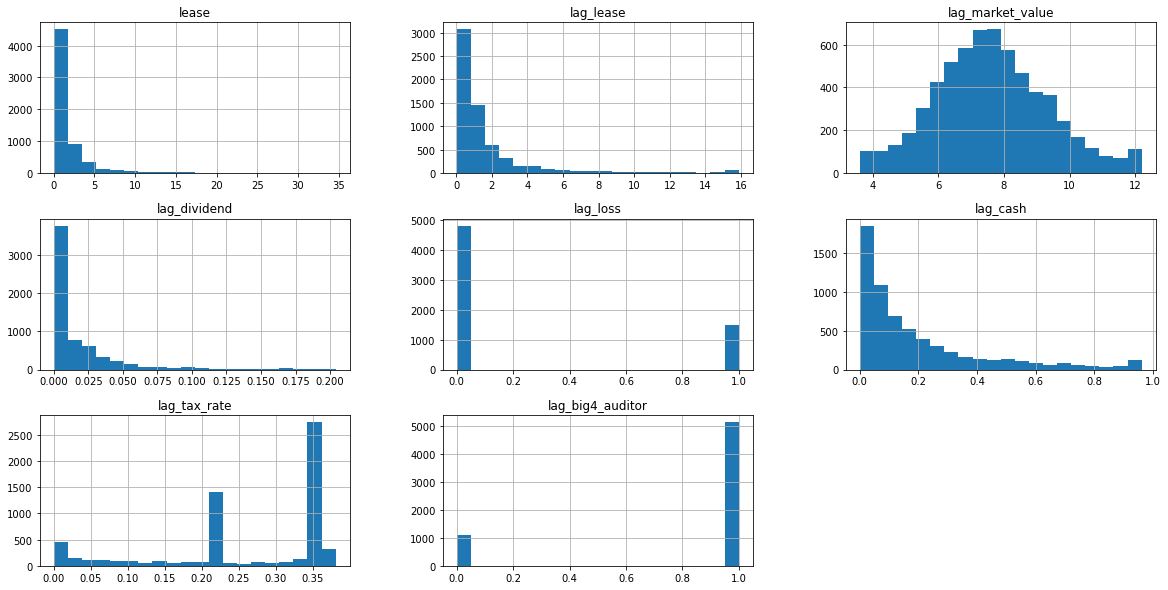

In [348]:
# Show histograms - all variables except for the identifier
sample_with_outliers.drop(columns='identifier').hist(bins = 20, figsize =(20, 10))
plt.show()

#### 2.4. Drop variables without outliers
The above two panels show that lag_loss and lag_big4_auditor are indicator variables and thus do not have outliers. 

In addition, the histogram suggests that lag_tax_rate also does not have outliers. During the sample period (2016-2019), the corporate tax rate was reduced from 35% to 21%. Two big spikes in the histogram around 35% and 21% and all other values smaller than 35% make economic sense.

Therefore, I drop these three variables that do not have outliers.

In [349]:
# Drop identifier, lag_loss, lag_big4_auditor, and lag_tax_rate 
sample_z_score = sample_with_outliers.drop(columns=['identifier', 'lag_loss', 'lag_big4_auditor', 'lag_tax_rate'])

### 3. Z-Score - Detect and Remove Outliers
Before implementing Isolation Forest, I will first attempt to detect outliers using the Z-score method.

As indicated in a previous section, the Z-Score method is effective in addressing outliers for data points that follow a normal distribution.

The z-score indicates the distance of a data point from the mean as the number of standard deviations. The formula is as follows:

<img src="https://github.com/youngdataspace/treat-outliers/blob/main/Z%20Score.JPG">


I am going to assume that observations with a Z-score below -2.5 or above 2.5 (i.e., 2.5 standard deviations away from the mean; 1% of the sample) are outliers.

#### 3.1. lag_market_value - Identify and remove outliers
The histogram above shows that lag_market_value follows a normal distribution. To detect outliers, I first write a function to print the upper limits and lower limits of the Z-Score.

In [350]:
# Create a function to report the upper and lower limits of the Z-Score
def print_z_score_limits (dataframe, column_name):
    """ Print the upper and lower limits of the Z-score """
    
    # Compute the limits
    upper_limit = dataframe[column_name].mean() + 3 * dataframe[column_name].std()
    lower_limit = dataframe[column_name].mean() - 3 * dataframe[column_name].std()
    
    # Round and return the limits
    upper_limit = round(upper_limit, 2)
    lower_limit = round(lower_limit, 2)
    print_this = "Variable Name: " + column_name + " | Upper limit: " + str(upper_limit) + " | Lower limit: " + str(lower_limit)
    return(print_this)

In [351]:
# Print the upper and lower limits
print_z_score_limits(sample_z_score, "lag_market_value")

'Variable Name: lag_market_value | Upper limit: 12.82 | Lower limit: 2.43'

It turns out that all of the values (N=6,279) are within the boundary values of 2.43 and 12.81. Thus, none of the observations are trimmed.

In [352]:
# Filter outliers
sample_z_score = sample_z_score[(sample_z_score['lag_market_value'] >= 2.43) | (sample_z_score['lag_market_value'] <= 12.82)]
print(sample.shape)

(6279, 4)


I'll drop lag_market_value since an outlier treatment is not necessary for this feature.

In [353]:
# Drop lag_market_value
sample_z_score = sample_z_score.drop(columns=['lag_market_value'])

#### 3.2. Log transformation of other variables
Going back to the histogram above, we can see that lease, lag_lease, lag_dividend, and lag_cash are all significantly right skewed. In this case, the Z-Score method or many other popular outlier detection methods such as the Interquartile Range (IQR) method won't do any good. To address this issue, I conduct log transformations on these variables to see if I can describe them with normal distribution.

The histogram also shows that the four variables have many zeros (or very small values), which make economic sense. Therefore, I will only look for outliers on the right-hand side of the distribution. 

First, I will replace zeros with NaNs. This is okay because zeros will not be considered outliers.

In [354]:
# Replace zeros with NaNs
sample_z_score['lag_dividend'] = sample_z_score['lag_dividend'].replace([0],np.NaN)
sample_z_score['lease'] = sample_z_score['lease'].replace([0],np.NaN)

Next, I perform the log transformations and plot histograms

In [355]:
# Create a function to conduct log transformation
def log_transformation_function (dataframe, column_name):
    """ Conduct a log transformation of a variable """
    # Replace the values with log-transformed values
    dataframe[[column_name]] = dataframe[[column_name]].apply(np.log)

# Conduct log transformation on all the variables
for column in sample_z_score:
    log_transformation_function(sample_z_score, column)   

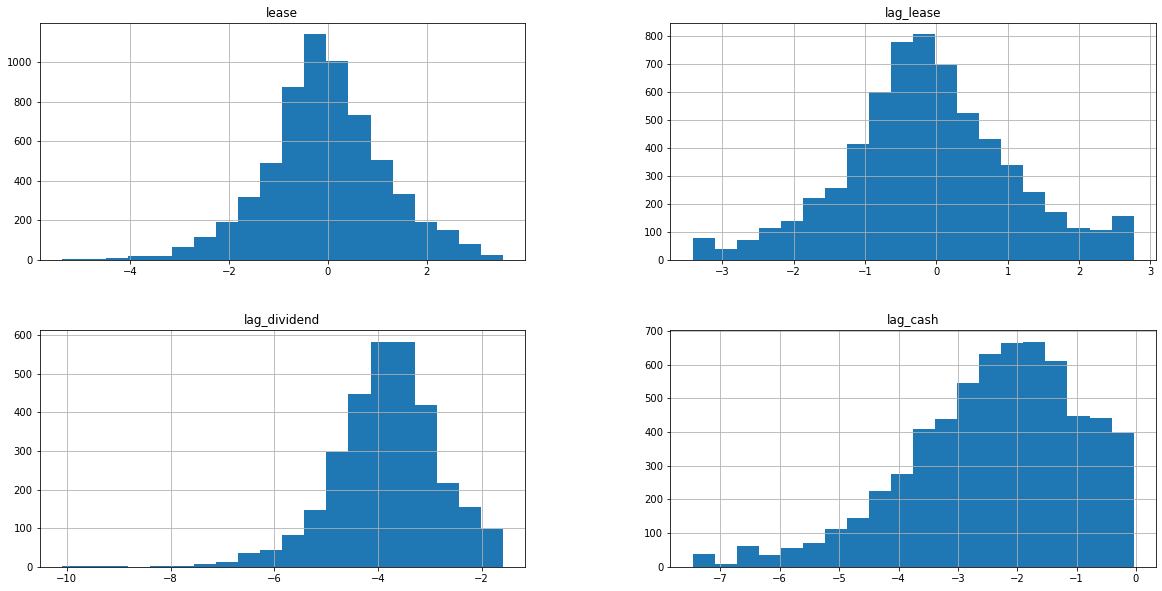

In [356]:
# Plot histrograms
sample_z_score.hist(bins = 20, figsize =(20, 10))
plt.show()

#### 3.3. Other variables - Identify and remove outliers
The distibutions now look much more like normal distributions. Once again, I will use the Z-Score to identify outliers.

First, I report the Z-Score upper limits for each variable.

In [357]:
# Print the upper and lower limits
for column in sample_z_score:
    print(print_z_score_limits(sample_z_score, column))

Variable Name: lease | Upper limit: 3.55 | Lower limit: -3.64
Variable Name: lag_lease | Upper limit: 3.42 | Lower limit: -3.66
Variable Name: lag_dividend | Upper limit: -0.8 | Lower limit: -6.86
Variable Name: lag_cash | Upper limit: 1.97 | Lower limit: -6.76


Next, I report the maximum values of each variable.

In [358]:
# Print the maximum values
print("MAXIMUM VALUES")
print(round(sample_z_score.max(),2))   

MAXIMUM VALUES
lease           3.54
lag_lease       2.76
lag_dividend   -1.59
lag_cash       -0.04
dtype: float64


All of the maximum values are smaller than the upper limits. Thus, none of the variables seems to have outliers.

### 4. Isolation Forest - Multidimensional Outlier Detection
Although the data points do not seem to have outliers at the variable level, there could be outliers at a multidimensional  level. Therefore, I employ Isolation Forest to detect outliers.

#### 4.1. Setup
I begin by dropping the identifier from the original sample.

In [410]:
sample_isf = sample_with_outliers.drop(columns='identifier')

#### 4.2. Conduct Principal Component Analysis (PCA)
I conduct PCA to reduce the firm feature dimensions from 7 to 2. Note that this step is not necessary because Isolation Forest works fine with multidimensions. Regardless, I am first reducing dimensions to later visualize the outlier points in my data.

In [411]:
# Standardize features
sample_scaled = StandardScaler().fit_transform(sample_isf)

# Conduct the PCA
pca = PCA(n_components=2)                             # The number of components = 2
principal_comp = pca.fit_transform(sample_scaled)     # Conduct dimentionality reduction

# Convert to dataframe
pca_df = pd.DataFrame(data = principal_comp, columns = ['principal_component_1', 'principal_component_2'])
pca_df.head()

,principal_component_1,principal_component_2
0,-0.941123,-0.078371
1,-0.908097,0.062997
2,-0.984182,-0.140106
3,-0.352054,-0.265954
4,1.168329,-0.220572


#### 4.3. Train the model and make predictions
As indicated before, we need to pre-define outlier frequency. After experimenting with data, I decide to use 4%. 

In [412]:
# Train the model
isf = IsolationForest(contamination=0.04)
isf.fit(pca_df)

# Predictions
predictions = isf.predict(pca_df)

#### 4.3. Extract predictions and isolation scores

In [413]:
# Extract scores
pca_df["iso_forest_scores"] = isf.decision_function(pca_df)

# Extract predictions
pca_df["iso_forest_outliers"] = predictions

# Describe the dataframe
pca_df.describe()

,principal_component_1,principal_component_2,iso_forest_scores,iso_forest_outliers
count,6.279000e+03,6.279000e+03,6279.000000,6279.000000
mean,1.412931e-16,-6.195607e-17,0.159795,0.919732
std,1.476402e+00,1.413903e+00,0.072919,0.392577
min,-3.451216e+00,-1.375379e+00,-0.160233,-1.000000
25%,-1.047614e+00,-7.105370e-01,0.121420,1.000000
50%,-3.918832e-01,-4.407937e-01,0.184542,1.000000
75%,6.940018e-01,9.532932e-02,0.217817,1.000000
max,4.864363e+00,1.051720e+01,0.240383,1.000000


Let's replace "-1" with "Yes" and "1" with "No"

In [418]:
# Replace "-1" with "Yes" and "1" with "No"
pca_df['iso_forest_outliers'] = pca_df['iso_forest_outliers'].replace([-1, 1], ["Yes", "No"])

# Print the first 5 firms
pca_df.head()

,principal_component_1,principal_component_2,iso_forest_scores,iso_forest_outliers
0,-0.941123,-0.078371,0.202217,No
1,-0.908097,0.062997,0.199808,No
2,-0.984182,-0.140106,0.210285,No
3,-0.352054,-0.265954,0.230036,No
4,1.168329,-0.220572,0.170375,No


#### 4.4. Plots
Plot the firms in the 2-dimensional space in the following order.<br>
[1] All firms<br>
[2] Normal Firms vs. Outlier Firms<br>
[3] Isolation Forest Scores

In [419]:
# Create a function to plot firms on the 2-dimensional space
def plot_firms (dataframe, title, color = None):
    """ Plot firms on the 2-dimensional space """
    
    # Generate a scatter plot
    fig = px.scatter(pca_df, x="principal_component_1", y="principal_component_2", title=title, color=color)
    
    # Layout
    fig.update_layout(
        font_family="Courier New",
        font_color="blue",
        title_font_family="Courier New",
        title_font_color="red",
        legend_title_font_color="green"
    )
    
    # Show the plot
    fig.show()

# Plot [1] All firms
plot_firms(pca_df, "All Firms")


In [420]:
# [2] Normal Firms vs. Outlier Firms
plot_firms(dataframe=pca_df, title="Normal Firms vs. Outlier Firms", color='iso_forest_outliers')

In [421]:
# [3] Isolation Forest Scores
plot_firms(dataframe=pca_df, title="Isolation Forest Scores", color='iso_forest_scores')

#### 4.6. Observations
A few observations are in order.

According to the second plot above, most of the outer points are identified as outliers. These outliers correctly meet the outlier characteristics that they are "distant and few."